- 参考
    - https://pytorch.org/tutorials/intermediate/model_parallel_tutorial.html

## outline

- 数据并行是切数据（scattering inputs and gathering outputs），模型并行是切模型（shards）；
    - 模型并行：单卡放不下一份模型；
    - 将一份大模型，不同的层s切分到不同的卡上；
- device_map：Huggingface
- 模型并行 on ToyModel
- 模型并行：on ResNet
    - 不需要引入额外的 torch api 支持；

## huggingface 的支持

### device_map


```
"auto", "balanced", "balanced_low_0", "sequential"
```

- `auto`
    - GPU(s) > CPU (RAM) > Disk.

In [26]:
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
# /disk2/modelscope/Llama-2-7b-hf
# model = LlamaForCausalLM.from_pretrained("decapoda-research/llama-7b-hf",
#     load_in_8bit=True,
#     device_map="auto",
# )
model = LlamaForCausalLM.from_pretrained("/disk2/modelscope/Llama-2-7b-hf",
    load_in_8bit=True,
    device_map="auto",
)
for i, para in enumerate(model.named_parameters()):
#     print(f'{i}, {para[0]}\t {para[1].device} \t{para[1].dtype}')
    print(f'{i}, \t {para[1].device} \t{para[1].dtype}')

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

0, 	 cuda:0 	torch.float16
1, 	 cuda:0 	torch.int8
2, 	 cuda:0 	torch.int8
3, 	 cuda:0 	torch.int8
4, 	 cuda:0 	torch.int8
5, 	 cuda:0 	torch.int8
6, 	 cuda:0 	torch.int8
7, 	 cuda:0 	torch.int8
8, 	 cuda:0 	torch.float16
9, 	 cuda:0 	torch.float16
10, 	 cuda:0 	torch.int8
11, 	 cuda:0 	torch.int8
12, 	 cuda:0 	torch.int8
13, 	 cuda:0 	torch.int8
14, 	 cuda:0 	torch.int8
15, 	 cuda:0 	torch.int8
16, 	 cuda:0 	torch.int8
17, 	 cuda:0 	torch.float16
18, 	 cuda:0 	torch.float16
19, 	 cuda:0 	torch.int8
20, 	 cuda:0 	torch.int8
21, 	 cuda:0 	torch.int8
22, 	 cuda:0 	torch.int8
23, 	 cuda:0 	torch.int8
24, 	 cuda:0 	torch.int8
25, 	 cuda:0 	torch.int8
26, 	 cuda:0 	torch.float16
27, 	 cuda:0 	torch.float16
28, 	 cuda:1 	torch.int8
29, 	 cuda:1 	torch.int8
30, 	 cuda:1 	torch.int8
31, 	 cuda:1 	torch.int8
32, 	 cuda:1 	torch.int8
33, 	 cuda:1 	torch.int8
34, 	 cuda:1 	torch.int8
35, 	 cuda:1 	torch.float16
36, 	 cuda:1 	torch.float16
37, 	 cuda:1 	torch.int8
38, 	 cuda:1 	torch.int8
39, 	 cu

In [ ]:
# # 导入必要的库：LlamaTokenizer（分词器）、LlamaForCausalLM（模型）、GenerationConfig（生成配置）
# from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig

# # 注释说明模型路径为 "/disk2/modelscope/Llama-2-7b-hf"
# # 如果使用远程模型，原语句是：
# # model = LlamaForCausalLM.from_pretrained("decapoda-research/llama-7b-hf",
# #     load_in_8bit=True,
# #     device_map="auto",
# # )

# # 从本地路径加载 Llama-2-7b 模型，并启用 8-bit 量化（节省显存），自动分配设备（多 GPU 分布式加载）
# model = LlamaForCausalLM.from_pretrained("/disk2/modelscope/Llama-2-7b-hf",
#     load_in_8bit=True,
#     device_map="auto",
# )

# # 遍历模型的所有参数，打印参数索引、所在设备和数据类型
# for i, para in enumerate(model.named_parameters()):
#     # 打印格式：参数编号，参数所在的设备（如 cuda:0）和参数的数据类型（如 torch.float16）
#     print(f'{i}, \t {para[1].device} \t{para[1].dtype}')

## toy example

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim


class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()
        self.net1 = torch.nn.Linear(10000, 10).to('cuda:0')
        self.relu = torch.nn.ReLU()
        self.net2 = torch.nn.Linear(10, 5).to('cuda:1')

    def forward(self, x):
        x = self.relu(self.net1(x.to('cuda:0')))
        return self.net2(x.to('cuda:1'))


In [ ]:
import torch  # 导入 PyTorch 库，用于构建和训练深度学习模型
import torch.nn as nn  # 导入神经网络模块
import torch.optim as optim  # 导入优化器模块，用于参数更新


class ToyModel(nn.Module):
    def __init__(self):
        super(ToyModel, self).__init__()  
        # 调用父类 nn.Module 的构造函数。super() 函数的作用是调用父类的方法。
        # 这里使用的是 Python 2 风格的 super 写法，在 Python 3 中也可以简写为 super().__init__()
        # 在 PyTorch 中，所有自定义模型都应继承 nn.Module 并调用其初始化方法。

        self.net1 = torch.nn.Linear(10000, 10).to('cuda:0')  
        # 定义一个线性层（全连接层），输入维度为 10000，输出维度为 10，并将其移动到 GPU 0 上

        self.relu = torch.nn.ReLU()  
        # 定义 ReLU 激活函数层

        self.net2 = torch.nn.Linear(10, 5).to('cuda:1')  
        # 定义另一个线性层，输入维度为 10，输出维度为 5，并将其移动到 GPU 1 上

    def forward(self, x):
        x = self.relu(self.net1(x.to('cuda:0')))  
        # 将输入张量移动到 GPU 0，经过 net1 层处理后，通过 ReLU 激活函数
        return self.net2(x.to('cuda:1'))  
        # 将中间结果张量移动到 GPU 1，再经过 net2 层处理，返回最终输出

In [28]:
# watch -n 1 nvidia-smi
model = ToyModel()

In [29]:
type(list(model.net1.parameters())[0])

torch.nn.parameter.Parameter

In [30]:
print(next(model.net1.parameters()).device)
print(next(model.net2.parameters()).device)

cuda:0
cuda:1


In [31]:
model = ToyModel()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

optimizer.zero_grad()
outputs = model(torch.randn(20, 10000))
labels = torch.randn(20, 5).to('cuda:1')
loss_fn(outputs, labels).backward()
optimizer.step()

## split ResNet

- 简单介绍下 ResNet

```
model = ResNet(block, layers, **kwargs)

# resnet18
_resnet(BasicBlock, [2, 2, 2, 2])
# resnet34
_resnet(BasicBlock, [3, 4, 6, 3])

# resnet50
_resnet(Bottleneck, [3, 4, 6, 3])
# resnet101
_resnet(Bottleneck, [3, 4, 23, 3])
# resnet152
_resnet(Bottleneck, [3, 8, 36, 3])
```

In [32]:
import torch
from torch import nn
from torchvision.models.resnet import ResNet, Bottleneck
# from torchvision.models.resnet import resnet18, resnet34, resnet50, resnet101, resnet152

In [33]:
# resnet50
model = ResNet(Bottleneck, [3, 4, 6, 3])

In [34]:
# conv1 => bn1 => relu => maxpool => layer1-layer4 => avgpool => fc
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [35]:
from torchsummary import summary

In [36]:
summary(model, input_size=(3, 128, 128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

### 自定义模型并行

In [37]:
t = torch.rand((2, 3, 4))
print(t.shape)
t.view(t.size(0), -1).shape

torch.Size([2, 3, 4])


torch.Size([2, 12])

In [38]:
class ModelParallelResNet50(ResNet):
    def __init__(self, num_classes=1000):
        super().__init__(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)
        # conv1 => bn1 => relu => maxpool => layer1-layer4 => avgpool => fc
        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,
            self.layer1, 
            self.layer2
        ).to('cuda:0')
        
        self.seq2 = nn.Sequential(
            self.layer3, 
            self.layer4,
            self.avgpool,
        ).to('cuda:1')
        
        self.fc.to('cuda:1')
    
    def forward(self, x):
        # model parts（layers） 的一个（卡间）串行，
        x = self.seq2(self.seq1(x).to('cuda:1'))
        return self.fc(x.view(x.size(0), -1))

In [ ]:
# class ModelParallelResNet50(ResNet):
#     def __init__(self, num_classes=1000):
#         super().__init__(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)  # 调用父类ResNet的构造函数，初始化ResNet50模型结构
#         # conv1 => bn1 => relu => maxpool => layer1-layer4 => avgpool => fc
#         self.seq1 = nn.Sequential(
#             self.conv1,  # 第一层卷积层，负责提取输入图像的低级特征
#             self.bn1,   # 批归一化层，用于加速训练并提高模型稳定性
#             self.relu,  # 激活函数ReLU，引入非线性
#             self.maxpool,  # 最大池化层，降维并提取重要特征
#             self.layer1,  # ResNet的第一个残差块组，包含多个Bottleneck模块
#             self.layer2   # ResNet的第二个残差块组，进一步提取特征
#         ).to('cuda:0')  # 将seq1部分的计算分配到GPU 0上
        
#         self.seq2 = nn.Sequential(
#             self.layer3,  # ResNet的第三个残差块组，提取更深层次的特征
#             self.layer4,  # ResNet的第四个残差块组，负责高层次特征提取
#             self.avgpool,  # 全局平均池化层，将特征图降维为固定大小
#         ).to('cuda:1')  # 将seq2部分的计算分配到GPU 1上
        
#         self.fc.to('cuda:1')  # 将全连接层（分类器）分配到GPU 1上
    
#     def forward(self, x):
#         # model parts（layers） 的一个（卡间）串行，
#         x = self.seq2(self.seq1(x).to('cuda:1'))  # 输入x先经过seq1处理，然后通过`.to('cuda:1')`将结果从GPU 0传输到GPU 1，再由seq2处理
#         return self.fc(x.view(x.size(0), -1))  # 将特征展平并通过全连接层得到最终分类结果

In [39]:
def model_size(model):
    return sum([para.numel() for para in model.parameters()])

In [40]:
model_size(ResNet(Bottleneck, [3, 4, 6, 3]))

25557032

In [41]:
model_size(ModelParallelResNet50())

25557032

### train pipeline

In [42]:
num_classes = 10

In [43]:
one_hot_indices = torch.LongTensor(5) \
                           .random_(0, num_classes) \
                           .view(5, 1)
one_hot_indices

tensor([[0],
        [3],
        [1],
        [3],
        [9]])

In [44]:
labels = torch.zeros(5, num_classes) \
                      .scatter_(1, one_hot_indices, 1)
labels

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [45]:
num_classes = 1000
num_batches = 3
batch_size = 120
image_w = 128
image_h = 128


def train(model):
    model.train(True)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)

    one_hot_indices = torch.LongTensor(batch_size) \
                           .random_(0, num_classes) \
                           .view(batch_size, 1)

    for _ in range(num_batches):
        # generate random inputs and labels
        # (b, c, w, h)
        inputs = torch.randn(batch_size, 3, image_w, image_h)
        # one hot：(batch_size, num_classes)，行粒度只有一个为1 （one-hot）
        # scatter 的三个参数：dim, index, src
        labels = torch.zeros(batch_size, num_classes) \
                      .scatter_(1, one_hot_indices, 1)

        # run forward pass
        optimizer.zero_grad()
        outputs = model(inputs.to('cuda:0'))
#         print('outputs', outputs.shape)
        # run backward pass
        labels = labels.to(outputs.device)
        loss_fn(outputs, labels).backward()
        optimizer.step()

In [46]:
import matplotlib.pyplot as plt
# plt.switch_backend('Agg')
import numpy as np
import timeit

num_repeat = 10

stmt = "train(model)"

# 模型并行
setup = "model = ModelParallelResNet50()"
mp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

# 单卡
setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)


def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('ResNet50 Execution Time (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()
#     plt.savefig(fig_name)
#     plt.close(fig)


In [ ]:
# import matplotlib.pyplot as plt  # 导入matplotlib库用于绘图
# # plt.switch_backend('Agg')  # 切换matplotlib的后端为Agg（非交互模式，适用于无图形界面环境）
# import numpy as np  # 导入numpy库用于数值计算
# import timeit  # 导入timeit库用于测量代码执行时间

# num_repeat = 10  # 定义重复运行次数为10次

# stmt = "train(model)"  # 定义要测试的语句，这里是调用train函数训练模型

# # 模型并行
# setup = "model = ModelParallelResNet50()"  # 定义模型初始化语句，使用自定义的ModelParallelResNet50类
# mp_run_times = timeit.repeat(  # 使用timeit.repeat测量模型并行的执行时间
#     stmt, setup, number=1, repeat=num_repeat, globals=globals())  # 测试语句、初始化语句、每个循环运行1次、重复10次、传入全局变量
# mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)  # 计算模型并行的平均时间和标准差

# # 单卡
# setup = "import torchvision.models as models;" + \  # 定义单卡模型的初始化语句，使用torchvision中的resnet50模型
#         "model = models.resnet50(num_classes=num_classes).to('cuda:0')"  # 将模型加载到cuda:0设备上
# rn_run_times = timeit.repeat(  # 使用timeit.repeat测量单卡模型的执行时间
#     stmt, setup, number=1, repeat=num_repeat, globals=globals())  # 测试语句、初始化语句、每个循环运行1次、重复10次、传入全局变量
# rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)  # 计算单卡模型的平均时间和标准差


# def plot(means, stds, labels, fig_name):  # 定义绘图函数
#     fig, ax = plt.subplots()  # 创建一个画布和子图
#     ax.bar(np.arange(len(means)), means, yerr=stds,  # 绘制柱状图，x轴为索引，y轴为平均值，误差条为标准差
#            align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)  # 设置柱状图样式：居中对齐、透明度、误差条颜色、误差条帽大小、柱宽
#     ax.set_ylabel('ResNet50 Execution Time (Second)')  # 设置y轴标签为“ResNet50执行时间（秒）”
#     ax.set_xticks(np.arange(len(means)))  # 设置x轴刻度为索引
#     ax.set_xticklabels(labels)  # 设置x轴刻度标签为传入的标签
#     ax.yaxis.grid(True)  # 启用y轴网格线
#     plt.tight_layout()  # 自动调整布局以避免重叠
# #     plt.savefig(fig_name)  # 保存图像到文件（注释掉）
# #     plt.close(fig)  # 关闭画布（注释掉）

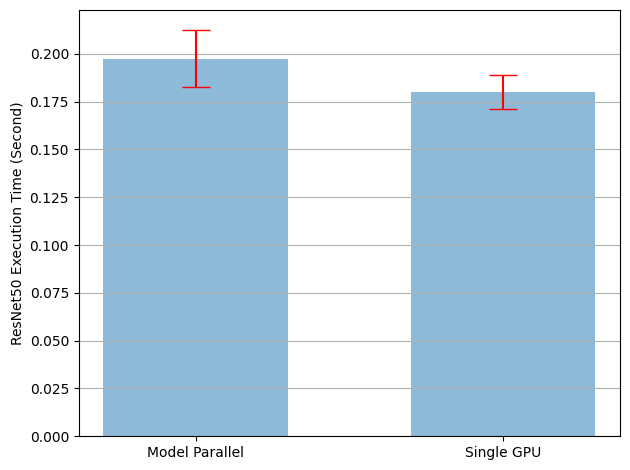

In [47]:
plot([mp_mean, rn_mean],
     [mp_std, rn_std],
     ['Model Parallel', 'Single GPU'],
     'mp_vs_rn.png')

In [48]:
mp_mean, rn_mean

(np.float64(0.19741040412336588), np.float64(0.17997694667428732))

In [49]:
(mp_mean-rn_mean)/rn_mean

np.float64(0.09686494726810044)